# Robust Q Learning, Example: Unfair Coin Toss

Load everything

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import copy 
import random
import pandas as pd
from tqdm import tqdm
from scipy.stats import binom
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from Q_learning import *

In [2]:
plt.rcParams["figure.figsize"] = (6,5)
plt.rcParams['axes.labelsize'] = 16

Fix the Setting

In [3]:
nr_coins = 10
X = np.linspace(0,nr_coins,nr_coins+1)
A = np.array([-1,0,1])

def c(x,y):
    return np.abs(x-y)

def r(x,a,y):
    return a*(y>x)- a*(y<x) #-np.abs(a)*(x==y) # You get a

def P_0(x,a):
    return binom.rvs(nr_coins, 0.5)

def p_0(k,x,a):
    return binom.pmf(k,nr_coins,0.5)

alpha = 0.45 # Discount Factor
x_0 = 5 # Initial Value
def c(x,y):
    return np.abs(x-y)

Compute the Wasserstein-distance between two binomial distributions:

$$
W\bigg(Bin(n,p_1),Bin(n,p_2)\bigg)= |p_1-p_2|\cdot n
$$

In [4]:
def Wasserstein_distance(p1,p2):
    return np.sum([np.abs(binom.cdf(k,nr_coins, p1)-binom.cdf(k,nr_coins, p2)) for k in range(nr_coins+1)])

Compute the Q Value functions (and therefore the optimal Value functions)

In [5]:
Nr_iter = 50000
epsilon_list = np.arange(0,1.1,0.1)
V_list = []
for eps in epsilon_list:
    Q_opt_robust_eps = robust_q_learning(X,
                   A,
                   r,
                   c,
                   P_0, # Simulation of next state in dependence of x and a
                   p_0, # The probability mass function
                   eps, #epsilon
                   alpha,
                   x_0, 
                   eps_greedy = 0.1,
                   Nr_iter = Nr_iter,
                   q =1,
                   gamma_t_tilde = lambda t: 1/(t+1),
                   Q_0 = np.ones([len(X),len(A)]))
    V_list.append(np.max(Q_opt_robust_eps,1))
Q_opt_nonrobust = q_learning(X,
               A,
               r,
               P_0, # Simulation of next state in dependence of x and a
               alpha,
               x_0, 
               eps_greedy = 0.1,
               Nr_iter = Nr_iter,
               gamma_t_tilde = lambda t: 1/(t+1),
                Q_0 = np.ones([len(X),len(A)]))
V_non_robust = np.max(Q_opt_nonrobust,1)

100%|██████████| 50000/50000 [00:08<00:00, 5669.83it/s]


Bound

We have 

$$
\alpha = 0.45
$$

Lipschitz constant:
$$
L_r = \left(\max_{y_0,y_0',x_1,x_1'\in \mathcal{X},~b,b'\in A \atop (y_0,b,x_1) \neq (y_0',b',x_1')} \frac{|r(y_0,b,x_1)-r(y_0',b',x_1')|}{\|y_0-y_0'\|+\|b-b'\|+\|x_1-x_1'\|}\right) \cdot \left(\|x_0-x_0'\|+\|a-a'\|+\|x_1-x_1'\|\right) \leq 1.
$$
Moreover,
We have $\mathbb{P}^{\rm{true}}(x,a) = \rm{Bin}(10,0.5)$ for all $x\in \mathcal{X}, a \in A$. Hence
$
d_{W_q}\left(\mathbb{P}^{\rm{true}}(x,a),\mathbb{P}^{\rm{true}}(x',a')\right) =0 \leq L_P (\|x-a\|+\|x'-a'\|)
$
for any $L_P>0$


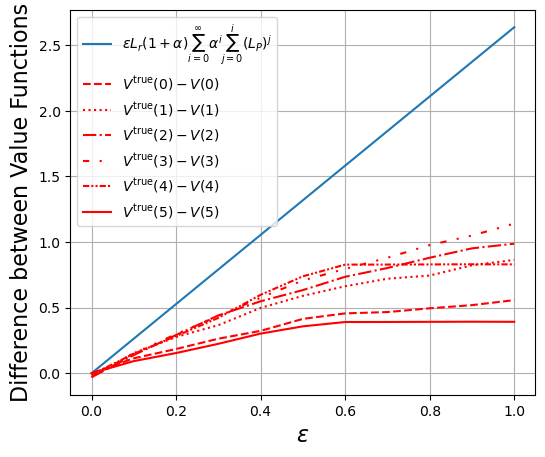

In [18]:
def bound(Lr,Lp,eps,alpha,n_sum):
    factor_1 = Lr*eps*(1+alpha)
    total_sum =0
    for i in range(n_sum):
        total_sum += (alpha**i)*((1-Lp**(i+1))/(1-Lp))
    return factor_1*total_sum
bounds = [bound(Lr=1,
                Lp=0,
                eps=epsilon,
                alpha = 0.45,
                n_sum = 10000) for epsilon in epsilon_list]
plt.plot(epsilon_list,bounds,label = r"$\varepsilon L_r(1+\alpha)\sum_{i=0}^{\infty} \alpha^i \sum_{j=0}^i (L_P)^j$")
plt.plot(epsilon_list,[V_non_robust[0]-V[0]for V in V_list],label = r"$V^{\rm true}(0)-V(0)$",
         linestyle = "dashed",color = "red")
plt.plot(epsilon_list,[V_non_robust[1]-V[1]for V in V_list],label = r"$V^{\rm true}(1)-V(1)$",
         linestyle = "dotted",color = "red")
plt.plot(epsilon_list,[V_non_robust[2]-V[2]for V in V_list],label = r"$V^{\rm true}(2)-V(2)$",
         linestyle = "dashdot",color = "red")
plt.plot(epsilon_list,[V_non_robust[3]-V[3]for V in V_list],label = r"$V^{\rm true}(3)-V(3)$",
         linestyle = (0, (3, 5, 1, 5, 1, 5)),color = "red")
plt.plot(epsilon_list,[V_non_robust[4]-V[4]for V in V_list],label = r"$V^{\rm true}(4)-V(4)$",
         linestyle = (0, (3, 1, 1, 1, 1, 1)),color = "red")
plt.plot(epsilon_list,[V_non_robust[5]-V[5]for V in V_list],label = r"$V^{\rm true}(5)-V(5)$",
         linestyle = "solid",color = "red")
plt.xlabel(r"$\varepsilon$")
plt.ylabel("Difference between Value Functions")
plt.legend()
plt.grid(True)
plt.savefig('plt_coin_toss_bounds_no_penalty_equal.pdf', format='pdf',bbox_inches='tight')
plt.show()